<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Decicion Tree Classifier
 - <span style="color:dodgerblue;"> **Pros:**
   - <span style="color:black;"> Handling Imbalance ( class_weight={1:N} )
   - <span style="color:black;"> Fast Learner
   - <span style="color:black;"> Decision Tree Plot
 - <span style="color:deeppink;"> **Cons:**
   - <span style="color:black;"> Low Accuracy

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Objective:
 - To detect diabetes using Decision Tree Classifier and Ensemble Methods

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Libraries

In [1]:
import time, pickle

import numpy  as np
from   numpy import mean, std

import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',None)

from matplotlib import pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True)
from   seaborn import boxplot as BoxPlot

from imblearn.combine        import SMOTETomek, SMOTEENN

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier 
from sklearn.tree            import plot_tree

from sklearn.preprocessing   import scale, LabelEncoder 
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

from sklearn.metrics         import accuracy_score, recall_score, precision_score
from sklearn.metrics         import classification_report, ConfusionMatrixDisplay

from sklearn.ensemble        import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from imblearn.ensemble       import EasyEnsembleClassifier 

from sklearn.ensemble        import StackingClassifier, VotingClassifier

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading and Exploring the Data

In [2]:
# (input) importing Raw data

data_set_name    = 'Pima_Diabetes'
estimated_column = 'Class'

data_file  = 'Pima_Diabetes.csv'
data_sheet = 'Pima_Diabetes'

# needed parameters 
RANDOM_STATE =  3
SCORING      = 'accuracy'

# (auto)
df_raw = pd.read_csv( data_file, header=0 ) # , delimiter=','
print(f'there are {df_raw.shape[0]} rows and {df_raw.shape[1]} columns.')

df_raw.tail() 

there are 768 rows and 9 columns.


,Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


#####   

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Observing Random Records

In [3]:
np.random.seed(3)
cm = sns.light_palette('#ffcccb', as_cmap=True)

df_raw.sample(n=200).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
1,101,50,15,36,24.20,0.53,26,0
4,156,75,0,0,48.30,0.24,32,1
1,97,66,15,140,23.20,0.49,22,0
2,197,70,99,0,34.70,0.57,62,1
13,106,72,54,0,36.60,0.18,45,0
4,154,62,31,284,32.80,0.24,23,0
5,99,74,27,0,29.00,0.20,32,0
2,68,62,13,15,20.10,0.26,23,0
4,110,92,0,0,37.60,0.19,30,0
6,114,0,0,0,0.00,0.19,26,0


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Exploring The Data (Info & Describe)

In [4]:
print( df_raw.info() )
print('')
df_raw.describe().T.style.format(precision=1)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pregnancy        768 non-null    int64  
 1   Blood_Plasma     768 non-null    int64  
 2   Blood_Pressure   768 non-null    int64  
 3   Skin             768 non-null    int64  
 4   Test             768 non-null    int64  
 5   Body_Mass_Index  768 non-null    float64
 6   Pedi             768 non-null    float64
 7   Age              768 non-null    int64  
 8   Class            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None



,count,mean,std,min,25%,50%,75%,max
Pregnancy,768.0,3.8,3.4,0.0,1.0,3.0,6.0,17.0
Blood_Plasma,768.0,120.9,32.0,0.0,99.0,117.0,140.2,199.0
Blood_Pressure,768.0,69.1,19.4,0.0,62.0,72.0,80.0,122.0
Skin,768.0,20.5,16.0,0.0,0.0,23.0,32.0,99.0
Test,768.0,79.8,115.2,0.0,0.0,30.5,127.2,846.0
Body_Mass_Index,768.0,32.0,7.9,0.0,27.3,32.0,36.6,67.1
Pedi,768.0,0.5,0.3,0.1,0.2,0.4,0.6,2.4
Age,768.0,33.2,11.8,21.0,24.0,29.0,41.0,81.0
Class,768.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - No Empty Cells Found.
 - Features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - include 0 which is impossible, and means missing value
 - These 0s must be converted to np.nan

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Converting 0s to np.nan

In [5]:
Features_with_Missin_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index']

df_missing = df_raw.copy()
for ft in Features_with_Missin_Values:
    df_missing[ft] = df_missing[ft].replace(0,np.nan)
    
df_missing.head(10).style.\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
6,148.00,72.00,35.00,nan,33.60,0.63,50,1
1,85.00,66.00,29.00,nan,26.60,0.35,31,0
8,183.00,64.00,nan,nan,23.30,0.67,32,1
1,89.00,66.00,23.00,94.00,28.10,0.17,21,0
0,137.00,40.00,35.00,168.00,43.10,2.29,33,1
5,116.00,74.00,nan,nan,25.60,0.20,30,0
3,78.00,50.00,32.00,88.00,31.00,0.25,26,1
10,115.00,nan,nan,nan,35.30,0.13,29,0
2,197.00,70.00,45.00,543.00,30.50,0.16,53,1
8,125.00,96.00,nan,nan,nan,0.23,54,1


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Handling Missing Values by KNNImputer

In [6]:
from sklearn.impute import KNNImputer
imputer   = KNNImputer( n_neighbors=2, weights="distance" )   # 'distance', 'uniform'

# Features_with_Missin_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index'] 
X_Null    = df_missing[ Features_with_Missin_Values ].values.copy()
X_Treated = imputer.fit_transform( X_Null )

In [7]:
df_Treated    = pd.DataFrame(X_Treated, columns=Features_with_Missin_Values)
#df.columns   = [ Features_with_Missin_Values ]
df_no_missing = df_missing.copy()
df_no_missing[ Features_with_Missin_Values ] = df_Treated.copy()
print(f'there are {df_no_missing.shape[0]} rows and {df_no_missing.shape[1]} columns.') 

df_no_missing.sample(n=200).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

there are 768 rows and 9 columns.


Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
5,168.00,64.00,36.32,205.82,32.90,0.14,41,1
4,114.00,64.00,18.32,143.04,28.90,0.13,24,0
6,115.00,60.00,39.00,108.12,33.70,0.24,40,1
2,112.00,68.00,22.00,94.00,34.10,0.32,26,0
2,90.00,70.00,17.00,64.99,27.30,0.09,22,0
4,122.00,68.00,28.60,271.80,35.00,0.39,29,0
8,99.00,84.00,25.00,108.73,35.40,0.39,50,0
6,114.00,73.00,35.00,242.50,38.50,0.19,26,0
2,175.00,88.00,30.44,226.70,22.90,0.33,22,0
3,193.00,70.00,31.00,301.25,34.90,0.24,25,1


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - In Features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - The 0s are replaced with appropriate values.

** **

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Detecting Outliers by Boxplots

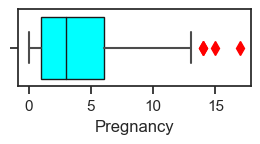

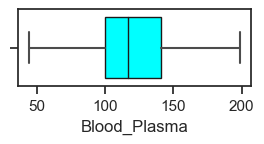

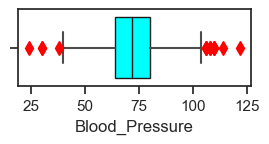

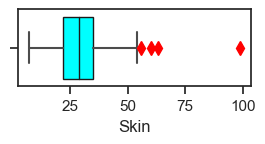

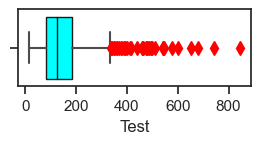

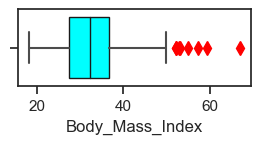

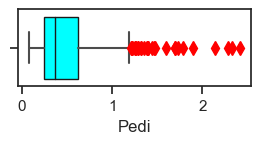

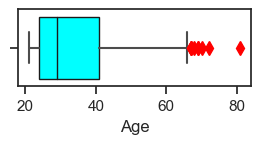

In [8]:
# (auto) 
df = df_no_missing.copy()

scalar_columns = []
for col in df.columns:
    if df[col].dtype!='object' and col!=estimated_column: scalar_columns.append( col )

boxprops    = dict( linewidth=1, edgecolor='k', facecolor='cyan' )
medianprops = dict( linewidth=1, color='k' )
flierprops  = dict( marker='d', markersize=7, markerfacecolor='red', markeredgecolor='red' )

for ft in scalar_columns:
    plt.figure(  figsize=(3,1)   )
    BoxPlot( x=df[ ft ] 
           , boxprops    = boxprops
           , medianprops = medianprops
           , flierprops  = flierprops  
           )
    plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - features: 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Pedi', 'Age'
   - have outliers and need treatment

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Treating Outliers

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Treating Outliers by Winsorizing

In [9]:
# Winsorizing Extreme Outliers
df_dirty = df_no_missing.copy()    
columns_with_outliers = [ 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Pedi', 'Age' ]

def winsorize_by_zscore(df,ft):
    x  = df[ft].copy()
    M  = x.mean()
    SD = x.std()
    z  = (x-M) / SD
    
    upper_bound = +3
    lower_bound = -3
    
    ls = df.index[ (z > upper_bound) 
                 | (z < lower_bound) ]
    
    x_Des=sorted(x,reverse=True)
    i=0
    while x_Des[i] >=  M + 3*SD:
        i=i+1 
    MAX=x_Des[i] 
    
    x_Asc=sorted(x,reverse=False)
    i=0 
    while x_Asc[i] <=  M - 3*SD:
        i=i+1  
    MIN=x_Asc[i] 
    
    for i in range(0,len(x)):
        if   z[i] > upper_bound: x[i]=MAX
        elif z[i] < lower_bound: x[i]=MIN
            
    return [x, ls]
 

# df_no_extreme
df_no_extreme = df_dirty.copy()

index_list = []
for c in columns_with_outliers:
    c_clean, ls = winsorize_by_zscore( df_dirty, c )
    index_list.extend( ls )
    df_no_extreme.loc[ :, c ] = c_clean

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Treating Noise (Outliers) by Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest

df_dirty = df_no_extreme.copy()    

X   = df_dirty[ scalar_columns ].values.copy()
AOD = IsolationForest( contamination=0.05 ).fit( X )
flag_clean = AOD.predict( X ) == +1
df_clean   = df_dirty.loc[ flag_clean, : ]
df_clean.index = range(df_clean.shape[0])

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Observing Outliers Before Vs After Treatment

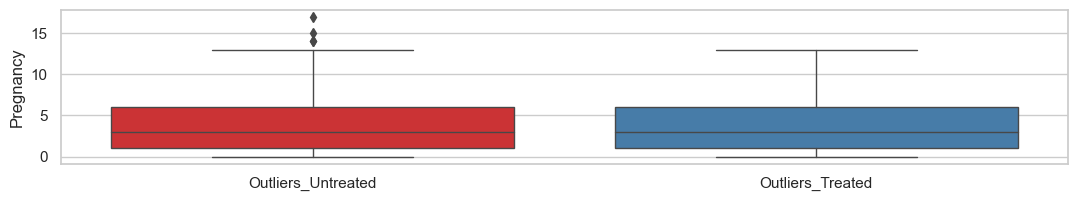

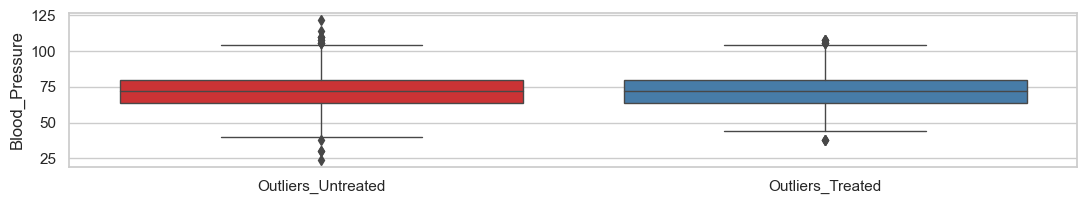

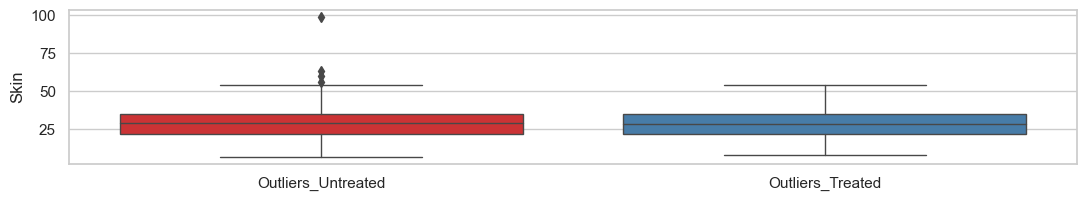

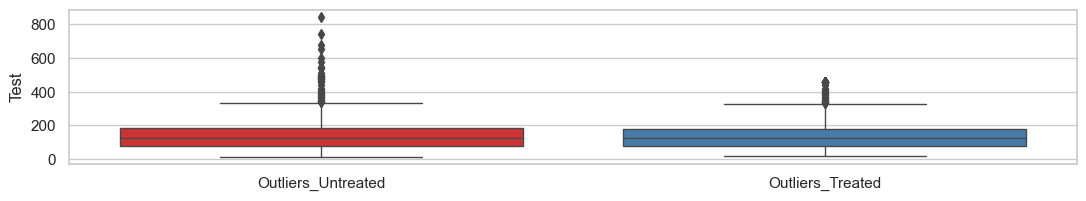

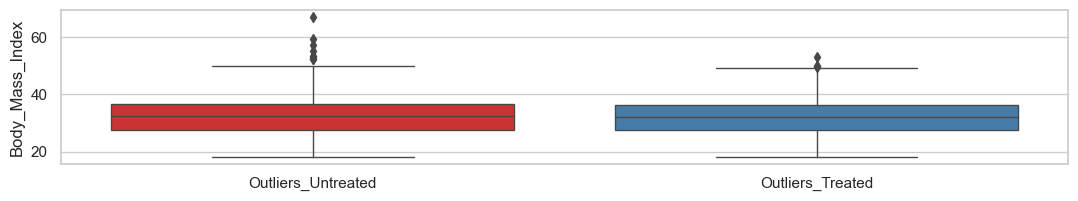

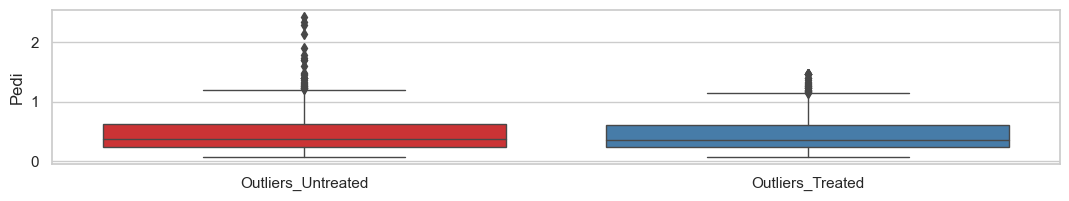

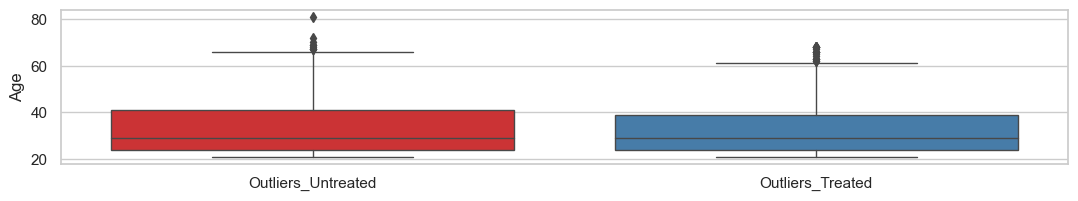

In [11]:
df_before = df_no_missing.copy()
df_before['condition']=['Outliers_Untreated']*df_before.shape[0]
df_after  = df_clean.copy()
df_after['condition'] =['Outliers_Treated']*df_after.shape[0]
df_before_after = pd.concat([df_before,df_after],axis=0)
df_before_after.head()

x   = 'condition'
for y in columns_with_outliers:
    df = df_before_after[ [x,y] ].copy().dropna().sort_values([x],ascending=[False]) 
    # BoxPlot
    sns.set(rc={'figure.figsize':(13,2)}); sns.set(style='whitegrid')
    sns_plot = sns.boxplot( x=x, y=y, data=df, linewidth=1.0, palette='Set1'); sns_plot.set_xlabel('')
    fig = sns_plot.get_figure(); plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - As expected, notable reduction in range and amount of outliers is achieved.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Feature Selection

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Correlations

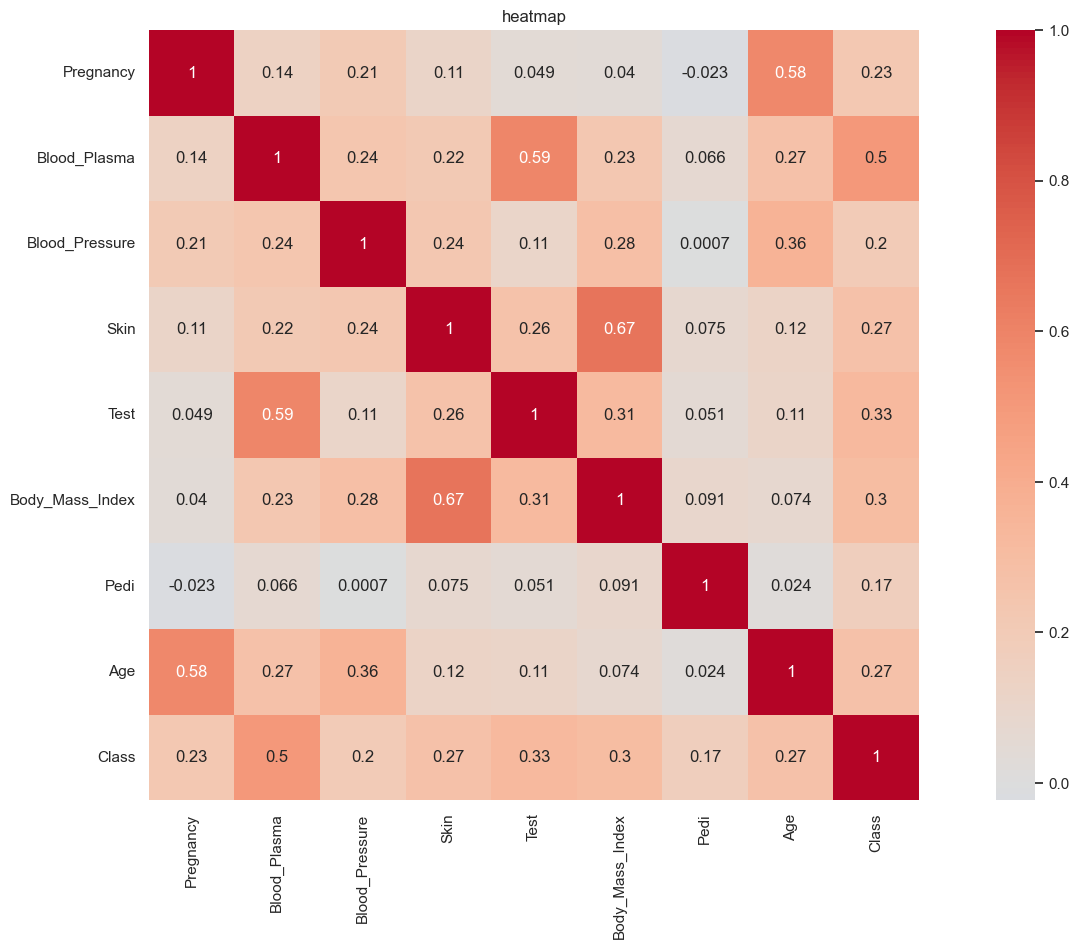

In [12]:
# heatmap
df = df_clean.copy() 

sns.set(style='whitegrid')
corr = df.corr('pearson')

fig,ax = plt.subplots(figsize=(20,10))
sns_plot = sns.heatmap( corr, mask=np.zeros_like(corr,dtype=bool), 
                        cmap='coolwarm',
                        square=True, ax=ax, annot=True, center=0.00 )
sns_plot.set( title="heatmap" )
 
fig = sns_plot.get_figure() 
fig.savefig('heatmap.png')

plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Chi-Squared Test

In [13]:
# Chi-Square Test
from sklearn.feature_selection import chi2 

# df
df = df_clean.copy()

X = df.drop([estimated_column],axis=1) 
y = df[estimated_column]
X_pvals = chi2(X,y)

# feature p values
# p value <= 0.05  means  strong feature
ft_pvals = pd.Series( X_pvals[1] )
ft_pvals.index = X.columns

# important & unimportant features
important_features   = list( ft_pvals[ft_pvals<=0.05].sort_values( ascending=True ).index )
unimportant_features = list( ft_pvals[ft_pvals> 0.05].sort_values( ascending=True ).index )

print( '\nChi-Squares P-Value Results:\n' )
print(    pd.DataFrame(ft_pvals,columns=['P_Value'])   )
print( '\n  Important_features:',   important_features )
print( '\nUnImportant_features:', unimportant_features )


Chi-Squares P-Value Results:

                       P_Value
Pregnancy         3.408920e-24
Blood_Plasma     1.571379e-289
Blood_Pressure    9.593018e-14
Skin              1.257707e-34
Test              0.000000e+00
Body_Mass_Index   1.027407e-19
Pedi              5.657509e-02
Age               5.588602e-46

  Important_features: ['Test', 'Blood_Plasma', 'Age', 'Skin', 'Pregnancy', 'Body_Mass_Index', 'Blood_Pressure']

UnImportant_features: ['Pedi']


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
 - Diabetes Class:
   - Extremely Depends on Features [ Test, Blood_Plasma ]
   - Highly Depends on Features [ Age, Skin, Pregnancy, Body_Mass_Index, Blood_Pressure ]
   - BUT is not dependent on Feature [ Pedi ].
 So, Feature [ Pedi ] Can Be Deleted.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Assigning Important Features
 - (Removing UnImportant Features)

In [14]:
df                     = df_clean[ important_features ].copy()
df[ estimated_column ] = df_clean[  estimated_column  ].copy()
df_clean               = df.copy()

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Train Valid Test Clean DataSets

In [15]:
df = df_clean.copy().sort_values([ estimated_column ],ascending=True)

# (auto)
X = df.drop( estimated_column, axis=1 ).copy() 
y = df[ estimated_column ].copy() 
 
X_Train_Valid, X_Test, y_Train_Valid, y_Test  =  train_test_split(        
          X, LabelEncoder().fit(y).transform(y)
        , random_state  =  RANDOM_STATE
        , test_size     =  10/100
        , shuffle       =  True 
        , stratify      =  y
        )
X_Train_Valid.index = range( X_Train_Valid.shape[0] )
X_Test.index        = range( X_Test.shape[0]  ) 

y_Train_Valid         = pd.DataFrame([y_Train_Valid,y_Train_Valid]).T
y_Train_Valid.columns = [ estimated_column, 'del' ]
y_Train_Valid.index   = range( y_Train_Valid.shape[0] )
y_Train_Valid         = y_Train_Valid[ estimated_column ]

X_Train, X_Valid, y_Train, y_Valid = train_test_split(        
          X_Train_Valid, LabelEncoder().fit(y_Train_Valid).transform(y_Train_Valid)
        , random_state  =  RANDOM_STATE
        , test_size     =  20/90
        , shuffle       =  True 
       #, stratify      =  y
        )
X_Train.index = range( X_Train.shape[0] )
X_Valid.index = range( X_Valid.shape[0] )

X_Clean = df_clean.drop([ estimated_column ],axis=1) 
y_Clean = np.array(df_clean[ estimated_column ])

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Checking Imbalance in Data

col_0  count
Class       
0        482
1        247


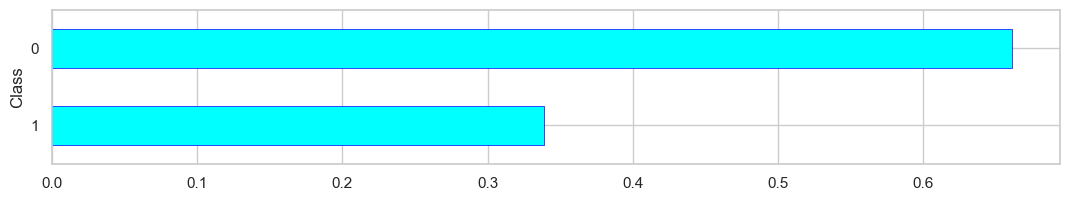

In [16]:
df = df_clean.copy()
x  = estimated_column

# Frequency Table  
freq_tab = pd.crosstab( index=df[x].astype('str'), columns='count' )
print(freq_tab.sort_values('count',ascending=False))

# Barh
L = df[x].astype('str')
L.value_counts(normalize=True).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan'); plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - Data is **Imbalanced** and needs treatment.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:red;"> Mistreating Imbalance

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Misreating Imbalance by SMOTETomek

In [17]:
Sampler = SMOTETomek()
X_Train_Balanced, y_Train_Balanced = Sampler.fit_resample( X_Train, y_Train )
X_Valid_Balanced, y_Valid_Balanced = Sampler.fit_resample( X_Valid, y_Valid )
X_Test_Balanced , y_Test_Balanced  = Sampler.fit_resample( X_Test , y_Test  )
X_Train_Balanced.index = range(X_Train_Balanced.shape[0])
X_Valid_Balanced.index = range(X_Valid_Balanced.shape[0])
X_Test_Balanced.index  = range(X_Test_Balanced.shape[0] )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Checking Balanced Data

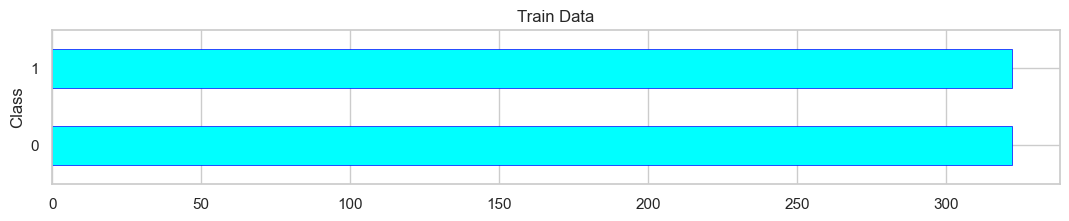

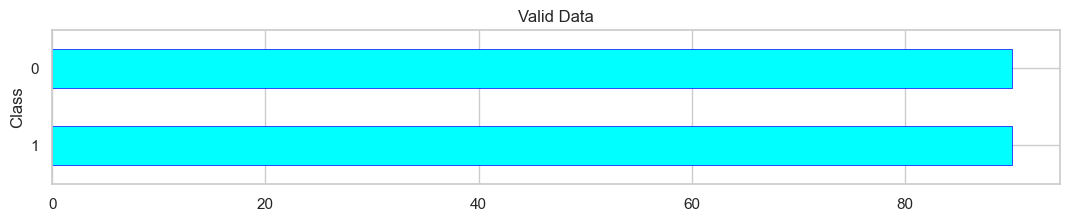

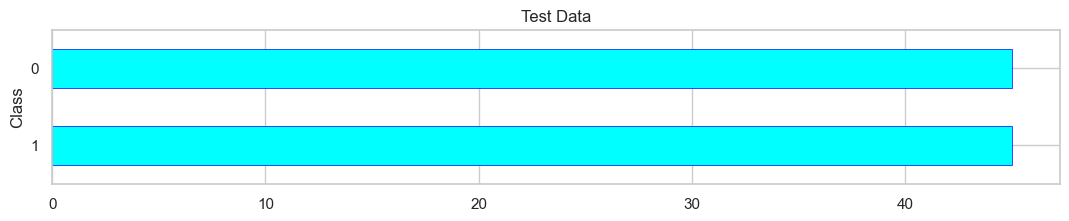

In [18]:
x = estimated_column

df_Train_Balanced      = X_Train_Balanced.copy()
df_Train_Balanced[ x ] = y_Train_Balanced.copy()

df_Valid_Balanced      = X_Valid_Balanced.copy()
df_Valid_Balanced[ x ] = y_Valid_Balanced.copy()

df_Test_Balanced       = X_Test_Balanced.copy()
df_Test_Balanced[ x ]  = y_Test_Balanced.copy()

# Train Data
df = df_Train_Balanced.copy() 
L  = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Train Data'); plt.show()

# Valid Data
df = df_Valid_Balanced.copy()
L  = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Valid Data'); plt.show()

# Test Data
df = df_Test_Balanced.copy()
L  = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Test Data'); plt.show()


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - After Mistreatment, Data is **Balanced**

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Warning: 
 - Although Mistreated Data looks Charming and Tempting, unfortunately, the models trained by them are overfit and have weak performance.
 - A better solution to overcome the imbalance, is to train the models with the imbalanced data, and boost them via gradient-boost.

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Assigning 

In [19]:
#X_Train = X_Train_Balanced.copy();           y_Train = y_Train_Balanced.copy()
#X_Valid = X_Valid_Balanced.copy();           y_Valid = y_Valid_Balanced.copy()
#X_Test  = X_Test_Balanced.copy();            y_Test  = y_Test_Balanced.copy()

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Observing Training Variables

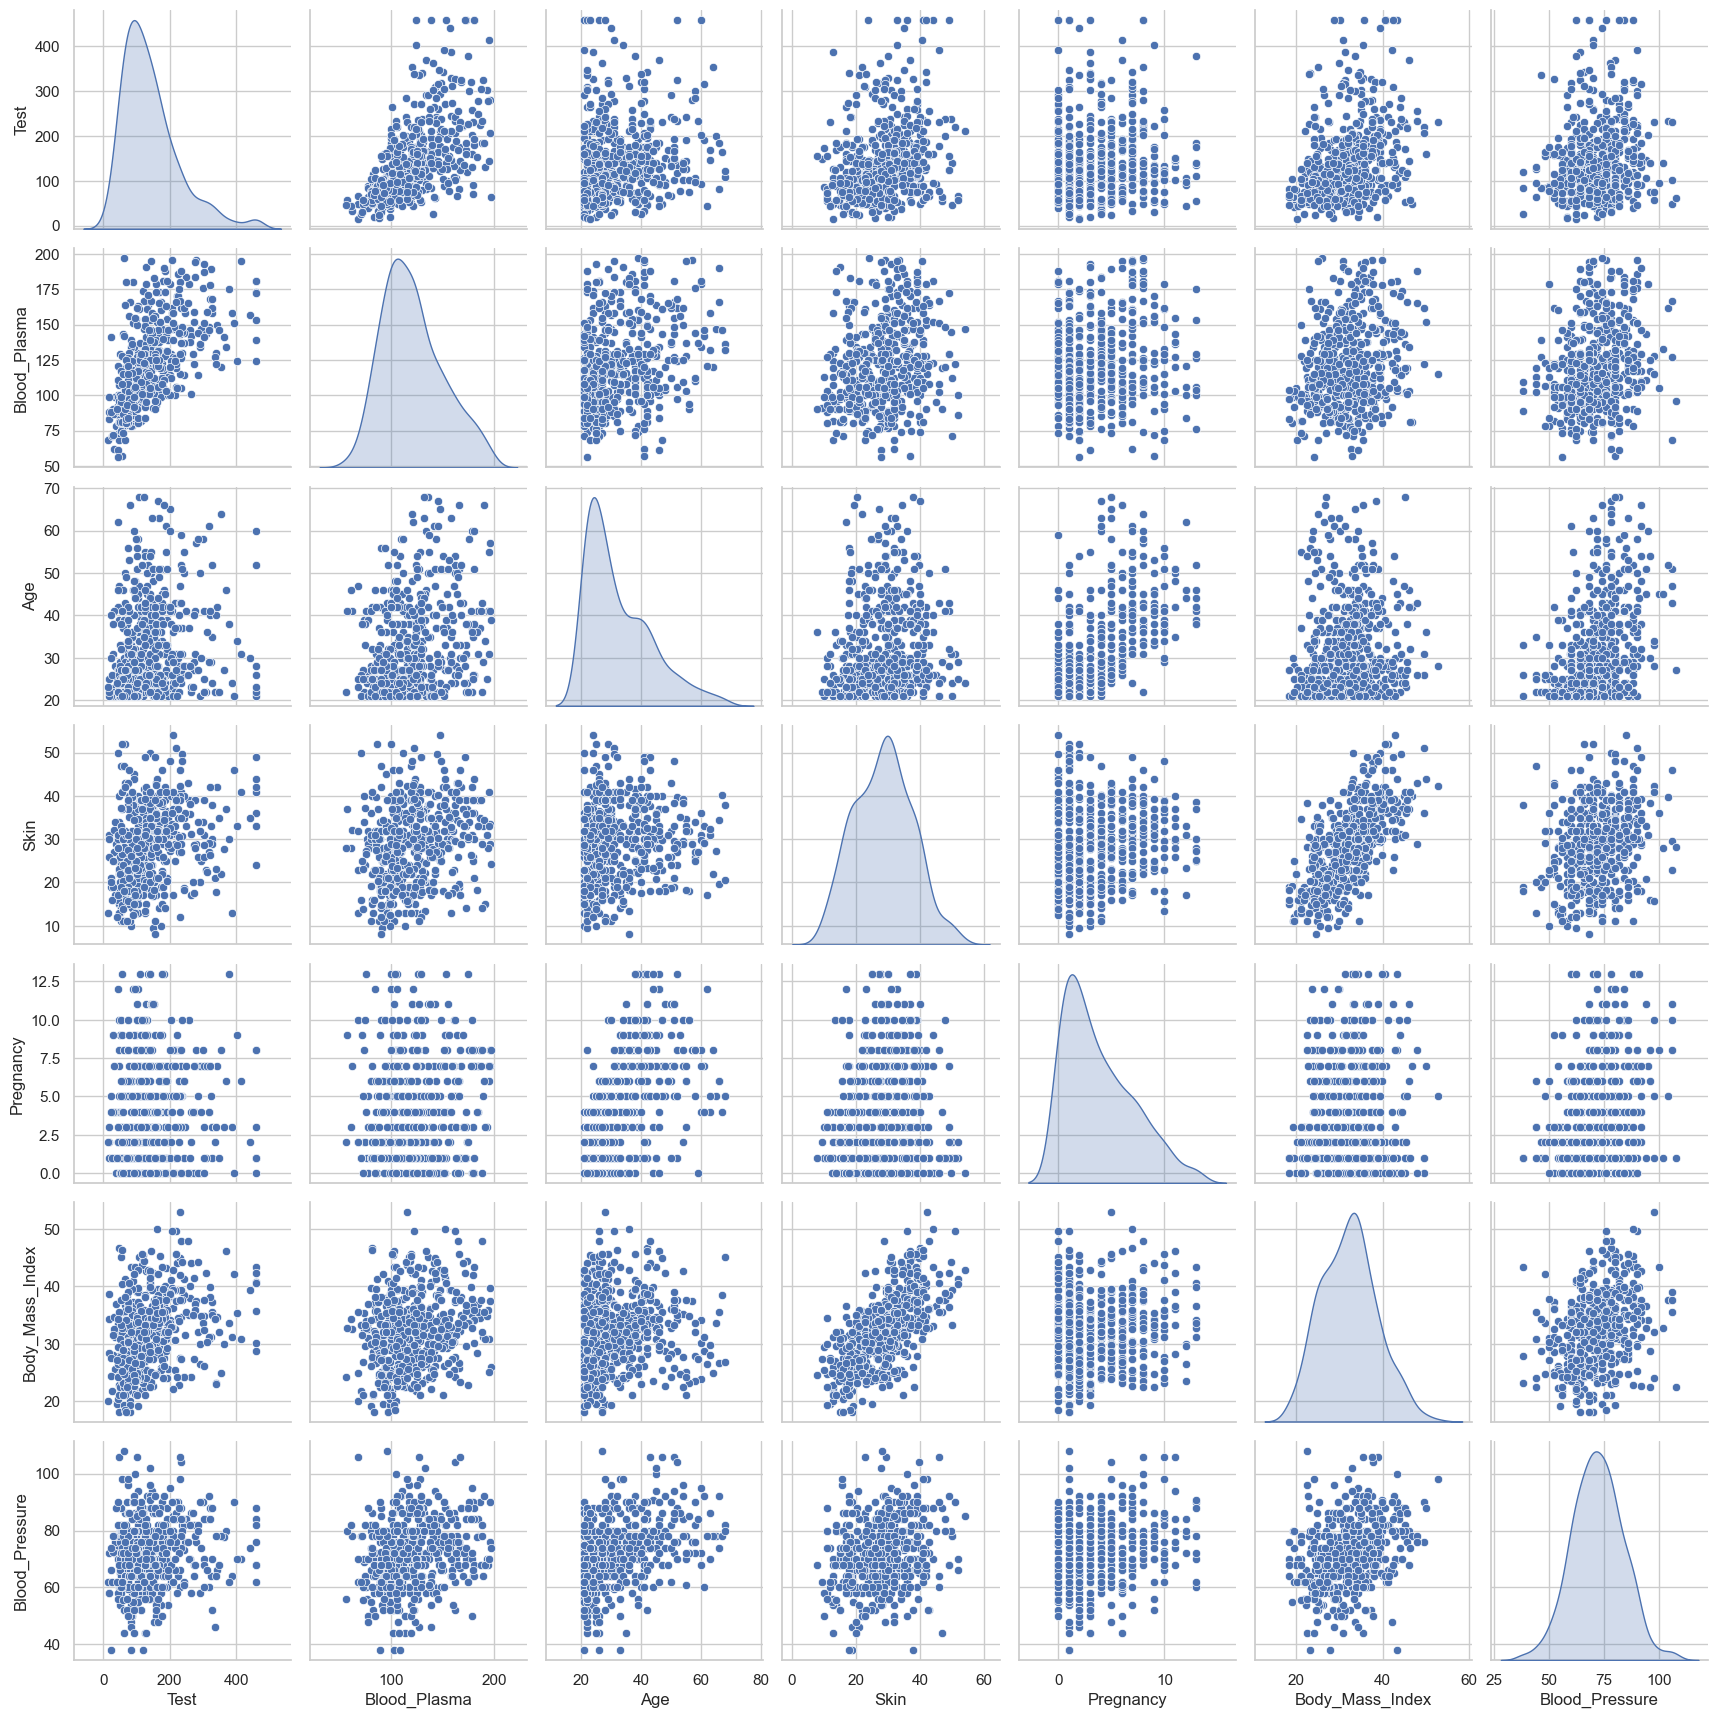

In [20]:
sns.pairplot( X_Train, diag_kind='kde' ); plt.show()

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Data Sets

In [21]:
from openpyxl       import Workbook
from openpyxl.utils import get_column_letter
from openpyxl       import load_workbook

wb = Workbook()
dest_filename = 'DataSets.xlsx'
Empty = wb.active; Empty.title='Empty'     


XX = df_clean.values.copy()    
dfClean = wb.create_sheet('dfClean')
dfClean.append( list(df_clean.columns) )
for i in range( XX.shape[0] ): dfClean.append( list( XX[i,:] )  )

    
XX = X_Train.values.copy()    
xTrain = wb.create_sheet('xTrain')
xTrain.append( list(X_Train.columns) )
for i in range( XX.shape[0] ): xTrain.append( list( XX[i,:] )  )
                                                  
YY = y_Train.copy()    
yTrain = wb.create_sheet('yTrain')
yTrain.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yTrain.append([  YY[i], YY[i]  ])

    
XX = X_Valid.values.copy()    
xValid = wb.create_sheet('xValid')
xValid.append( list(X_Valid.columns) )
for i in range( XX.shape[0] ): xValid.append( list( XX[i,:] )  )
                                                  
YY = y_Valid.copy()    
yValid = wb.create_sheet('yValid')
yValid.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yValid.append([  YY[i], YY[i]  ])

    
XX = X_Test.values.copy()    
xTest = wb.create_sheet('xTest')
xTest.append( list(X_Test.columns) )
for i in range( XX.shape[0] ): xTest.append( list( XX[i,:] )  )
                                                  
YY = y_Test.copy()    
yTest = wb.create_sheet('yTest')
yTest.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yTest.append([  YY[i], YY[i]  ])
    
    
XX = X_Clean.values.copy()    
xClean = wb.create_sheet('xClean')
xClean.append( list(X_Clean.columns) )
for i in range( XX.shape[0] ): xClean.append( list( XX[i,:] )  )
                                                  
YY = y_Clean.copy()    
yClean = wb.create_sheet('yClean')
yClean.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yClean.append([  YY[i], YY[i]  ])

    
# Saving    
wb.save( filename = dest_filename )   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Data Sets

In [22]:
DataSet  = 'DataSets.xlsx'

df_clean =           pd.read_excel( DataSet, 'dfClean', header=0 )

X_Train  =           pd.read_excel( DataSet, 'xTrain', header=0 )
y_Train  = np.array( pd.read_excel( DataSet, 'yTrain', header=0 ).iloc[:,0] )

X_Valid  =           pd.read_excel( DataSet, 'xValid', header=0 )
y_Valid  = np.array( pd.read_excel( DataSet, 'yValid', header=0 ).iloc[:,0] )

X_Test   =           pd.read_excel( DataSet, 'xTest',  header=0 )
y_Test   = np.array( pd.read_excel( DataSet, 'yTest',  header=0 ).iloc[:,0] )

X_Clean  =           pd.read_excel( DataSet, 'xClean',  header=0 )
y_Clean  = np.array( pd.read_excel( DataSet, 'yClean',  header=0 ).iloc[:,0] )

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Scaling Datasets

In [23]:
x_train_scaled , y_train  =  scale(X_Train) , y_Train
x_valid_scaled , y_valid  =  scale(X_Valid) , y_Valid
x_test_scaled  , y_test   =  scale(X_Test)  , y_Test
x_clean_scaled , y_clean  =  scale(X_Clean) , y_Clean

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Base-Line

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Finding The Class_Weight
 - A **Class_Weight** is calculated and inserted in Estimators to compensate for **Data Imbalance**.

In [24]:
df = pd.DataFrame([y_Train,y_Train]).T
df.columns = [estimated_column,'del']
df.index = np.arange( df.shape[0] )

freq_tab = pd.crosstab( index=df[estimated_column].astype('str'), columns='count' )
CLASS_WEIGHT = max(freq_tab['count'])/min(freq_tab['count'])

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making A Base-Line for DTree Estimators

In [25]:
DTree_BaseLine = DecisionTreeClassifier( class_weight = {1:CLASS_WEIGHT}
                                       , random_state =   RANDOM_STATE 
                                       ).fit( x_train_scaled, y_train )
print( '\nDTree_BaseLine Parameters: \n\n', DTree_BaseLine.get_params(), '\n' )


DTree_BaseLine Parameters: 

 {'ccp_alpha': 0.0, 'class_weight': {1: 1.9651162790697674}, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 3, 'splitter': 'best'} 



<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Evaluating The BaseLine on Validation Data

In [26]:
y_pred = DTree_BaseLine.predict( x_valid_scaled )
BaseLine_Report = classification_report( y_valid, y_pred )
print( BaseLine_Report )

              precision    recall  f1-score   support

           0       0.74      0.71      0.72        96
           1       0.48      0.52      0.50        50

    accuracy                           0.64       146
   macro avg       0.61      0.61      0.61       146
weighted avg       0.65      0.64      0.65       146



** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making Decision Tree Estimator

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [27]:
# Needed Data
N_SPLITS = 10

# Initiating
t1 = time.time()

# cross-validation strategy 
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# Hyper Parameters
CATs  = [ ['splitter'    , ['random','best']             ] 
        , ['criterion'   , ['gini','entropy','log_loss'] ] 
        #, ['class_weight', ['balanced',None]             ] 
        , ['max_features', ['sqrt','log2',None]          ]  
        ]
TFs   = [ 
        ]
INTs  = [ ['max_depth'     ,   1,  4,  4  ]
        , ['max_leaf_nodes',   2, 16, 15  ]
        ]
CONTs = [ [ 'ccp_alpha'               ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_samples_leaf'        ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_samples_split'       ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_impurity_decrease'   ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_weight_fraction_leaf',   1e-3, 0.5, 12,   'log-uniform' ]
        ] 
            
# General Estimator
ESTIMATOR  =  DecisionTreeClassifier( class_weight = {1:CLASS_WEIGHT}
                                    , random_state =   RANDOM_STATE 
                                    ) 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Defining Genetic Algorithm Optimizer

In [28]:
# pip install sklearn-genetic-opt
from sklearn_genetic           import GAFeatureSelectionCV, GASearchCV
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar
from sklearn_genetic.space     import Categorical as GA_Categorical 
from sklearn_genetic.space     import Integer     as GA_Integer 
from sklearn_genetic.space     import Continuous  as GA_Continuous 
from sklearn_genetic.plots     import plot_fitness_evolution
from sklearn_genetic.plots     import plot_search_space

# defining G.A. Optimizer
def GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR,CV,Search_Space_Features,SCORING
             , Pop_Size,   Gens,   Tours,   Crossover,   Mutation
             , x_train_scaled, y_train, x_valid_scaled, y_valid ):
    
    callbacks = [LogbookSaver( checkpoint_path="./GA_logbook_DTree.pkl"),ProgressBar()]
    
    param_grid = {}
    for item in CATs:  param_grid[item[0]]=GA_Categorical(item[1])
    for item in TFs:   param_grid[item[0]]=GA_Categorical([True,False])
    for item in INTs:  param_grid[item[0]]=GA_Integer(item[1],item[2])
    for item in CONTs: param_grid[item[0]]=GA_Continuous(item[1],item[2],distribution=item[4])

    optimal_params = GASearchCV(
          estimator=ESTIMATOR, cv=CV, param_grid=param_grid, scoring=SCORING, population_size=Pop_Size
        , generations=Gens, tournament_size=Tours, elitism=True, keep_top_k=10, crossover_probability=Crossover
        , mutation_probability=Mutation, criteria="max", algorithm="eaMuCommaLambda", n_jobs=-1 ) 

    print('initiating ...')
    optimal_params.fit( x_train_scaled, y_train, callbacks = callbacks )

    accuracy = optimal_params.score( x_valid_scaled, y_valid )  
    print('\n\nBest Parameters:', optimal_params.best_params_)
    print('accuracy =', accuracy)
    
    plot_search_space( optimal_params, features=Search_Space_Features )
    plt.show()           
        
    Top_Params = optimal_params.logbook.chapters["parameters"]    
    return [ optimal_params.best_params_ , Top_Params ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Tuning Hyper-Parameters

initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	5000  	0.487033	0.122701   	0.747059   	0.368627   
1  	9020  	0.750876	0.000498164	0.75098    	0.747059   
2  	9029  	0.772449	0.000439405	0.772549   	0.768627   


Best Parameters: {'splitter': 'best', 'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'max_leaf_nodes': 16, 'ccp_alpha': 0.0016998169159421444, 'min_samples_leaf': 0.012779350867053108, 'min_samples_split': 0.03409358899437604, 'min_impurity_decrease': 0.006406528139558546, 'min_weight_fraction_leaf': 0.012516850844818149}
accuracy = 0.7191780821917808


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


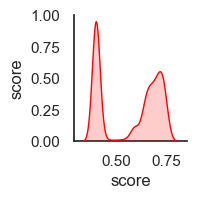


optimizing_time (min) = 29.0


In [29]:
# Initiating
t1 = time.time()

### Optimizing by G.A.
Pop_Size, Gens, Tours, Crossover, Mutation = 5000,2,15000, .30,.60 
Search_Space_Features   = [ 'score' ]
Best_Params, Top_Params = GA_Search(CATs,TFs,INTs,CONTs,ESTIMATOR,CV,Search_Space_Features,SCORING,
                                    Pop_Size,Gens,Tours,Crossover,Mutation, x_train_scaled, y_train, x_valid_scaled, y_valid )

t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making DTree

In [30]:
DTree = DecisionTreeClassifier(
    splitter='best', criterion='gini', max_features=None, max_depth=4, max_leaf_nodes=16, 
    ccp_alpha=0.0016998169159421444, min_samples_leaf=0.012779350867053108, min_samples_split=0.03409358899437604,
    min_impurity_decrease=0.006406528139558546, min_weight_fraction_leaf=0.012516850844818149,
    class_weight={1:CLASS_WEIGHT}, random_state=RANDOM_STATE 
                               ).fit( x_train_scaled, y_train )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Plotting DTree

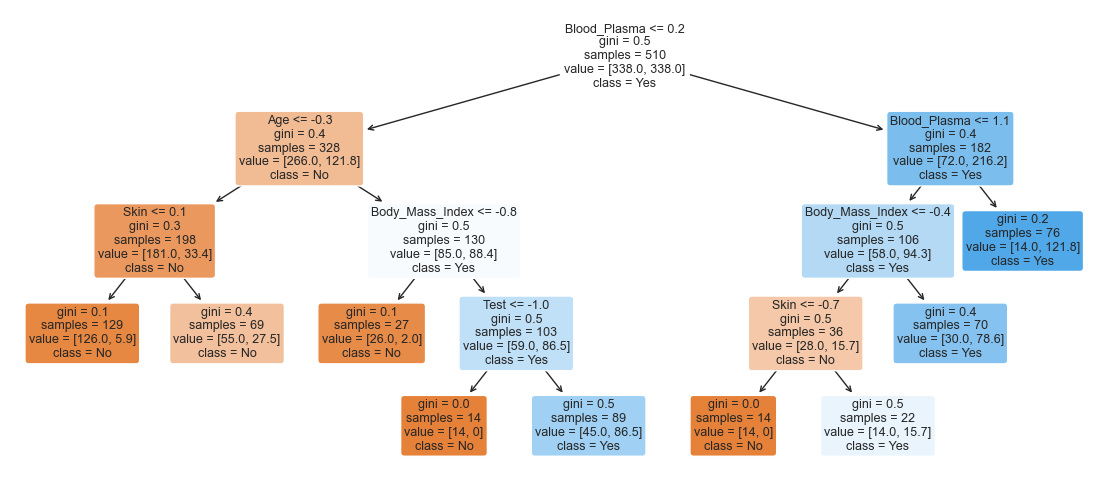

In [31]:
plt.figure( figsize=(14,6) )
plot_tree(  decision_tree  =  DTree
         ,  filled         =  True
         ,  rounded        =  True
         ,  fontsize       =  9
         ,  precision      =  1
         ,  class_names    =  ['No','Yes']
         ,  feature_names  =  X_Train.columns 
         ) 
plt.savefig( 'DTree_Plot.png',  dpi=120 )
plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Evaluating DTree

In [32]:
y_pred = DTree.predict( x_valid_scaled )
Report = classification_report( y_valid, y_pred )
print( Report )

              precision    recall  f1-score   support

           0       0.90      0.65      0.75        96
           1       0.56      0.86      0.68        50

    accuracy                           0.72       146
   macro avg       0.73      0.75      0.71       146
weighted avg       0.78      0.72      0.73       146



#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - Accuracy, Recall or Precision **< 80%** and need Boosting.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Gradient Boosting 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [33]:
# Needed Data
N_SPLITS = 10

# cross-validation strategy
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# (auto)
nClasses = len( df_clean[estimated_column].astype('str').unique() )
if nClasses == 2:
    LOSS_VALUES = ['log_loss','exponential']
else:
    LOSS_VALUES = ['log_loss']

# Hyper Parameters
CATs  = [ ['loss'        ,      LOSS_VALUES                 ]   
        , ['criterion'   , ['friedman_mse','squared_error'] ] 
        , ['max_features', ['sqrt','log2',None]             ]  
        ]
TFs   = [ ['warm_start']
        ]
INTs  = [ ['max_depth'     ,            1,  15, 15          ]
        , ['max_leaf_nodes',            2,  16, 15          ]
        , ['n_estimators'  ,           25, 101, 77          ]
        ,   
        ]
CONTs = [ [ 'tol'                     ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'ccp_alpha'               ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'subsample'               ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'learning_rate'           ,   1e-3, 0.3, 4,   'log-uniform' ]
        , [ 'min_samples_leaf'        ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_samples_split'       ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_impurity_decrease'   ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_weight_fraction_leaf',   1e-3, 0.5, 4,   'log-uniform' ]
        ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Tuning Hyper-Parameters

initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	500   	0.732129	0.0260261  	0.770588   	0.501961   
1  	888   	0.773945	0.00109006 	0.77451    	0.770588   
2  	890   	0.77451 	1.11022e-16	0.77451    	0.77451    


Best Parameters: {'loss': 'log_loss', 'criterion': 'squared_error', 'max_features': None, 'warm_start': True, 'max_depth': 11, 'max_leaf_nodes': 3, 'n_estimators': 59, 'tol': 0.0014550404952287678, 'ccp_alpha': 0.006403265716586865, 'subsample': 0.05879040924334701, 'learning_rate': 0.2547616807185664, 'min_samples_leaf': 0.01045792386401414, 'min_samples_split': 0.37264292378327196, 'min_impurity_decrease': 0.019788134411000698, 'min_weight_fraction_leaf': 0.46170168827712355}
accuracy = 0.7876712328767124


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


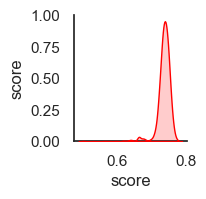


optimizing_time (min) = 19.0


In [34]:
# (manual)
INIT = DTree
#N_ESTIMATORS = 50

Pop_Size, Gens, Tours, Crossover, Mutation = 500,2,1500, .30,.60 
Search_Space_Features = [ 'score' ]

# (auto)
# Initiating
t1 = time.time()
# General Estimator 
ESTIMATOR  =  GradientBoostingClassifier( init                = DTree
                                        #, n_estimators        = N_ESTIMATORS
                                        , random_state        = RANDOM_STATE
                                        , verbose             = 0
                                        , n_iter_no_change    = None
                                        , validation_fraction = 0.1 
                                        )   
Best_Params, Top_Params = GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR, CV, Search_Space_Features, SCORING,
                                     Pop_Size,Gens,Tours,Crossover,Mutation, 
                                     x_train_scaled, y_train, x_valid_scaled, y_valid )
t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making Gradient Boosted Decision Tree

In [35]:
DTree_GrBoosted = GradientBoostingClassifier( init=DTree,
    loss='log_loss', criterion='squared_error', max_features=None, warm_start=True, max_depth=11, max_leaf_nodes=3,
    n_estimators=59, tol=0.0014550404952287678, ccp_alpha=0.006403265716586865, subsample=0.05879040924334701,
    learning_rate=0.2547616807185664, min_samples_leaf=0.01045792386401414, min_samples_split=0.37264292378327196,
    min_impurity_decrease=0.019788134411000698, min_weight_fraction_leaf=0.46170168827712355,
    random_state=RANDOM_STATE, verbose=0, n_iter_no_change=None, validation_fraction=0.1 
                                             ).fit( x_train_scaled, y_train )

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Adaptive Boosting 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [36]:
# Needed Data
N_SPLITS = 10

# cross-validation strategy
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# (auto) 
# Hyper Parameters
CATs  = [ ['algorithm'     ,        ['SAMME.R','SAMME']        ]   
        ]
TFs   = [ 
        ]
INTs  = [ ['n_estimators'  ,            25, 101, 77            ]
        ]
CONTs = [ [ 'learning_rate',   1e-3, 0.3, 4,   'log-uniform'   ] 
        ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Tuning Hyper-Parameters

initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	500   	0.727906	0.0166764  	0.776471   	0.682353   
1  	914   	0.77378 	0.00168857 	0.77451    	0.764706   
2  	894   	0.777584	0.00161378 	0.778431   	0.77451    


Best Parameters: {'algorithm': 'SAMME.R', 'n_estimators': 29, 'learning_rate': 0.0032635647827251135}
accuracy = 0.7876712328767124


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


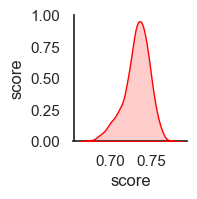


optimizing_time (min) = 51.0


In [37]:
# (manual)
INIT = DTree
#N_ESTIMATORS = 50

Pop_Size, Gens, Tours, Crossover, Mutation = 500,2,1500, .30,.60 
Search_Space_Features = [ 'score' ]

# (auto)
# Initiating
t1 = time.time()
# General Estimator 
ESTIMATOR  =  AdaBoostClassifier( estimator           = INIT
                                #,n_estimators        = N_ESTIMATORS
                                , random_state        = RANDOM_STATE  
                                )   
Best_Params, Top_Params = GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR, CV, Search_Space_Features, SCORING,
                                     Pop_Size,Gens,Tours,Crossover,Mutation, 
                                     x_train_scaled, y_train, x_valid_scaled, y_valid )
t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making Adaptive Boosted Decision Tree

In [38]:
DTree_AdaBoosted = AdaBoostClassifier( estimator=DTree, random_state=RANDOM_STATE,
    algorithm='SAMME.R', n_estimators=29, learning_rate=0.0032635647827251135,
                                     ).fit( x_train_scaled, y_train )

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making Stacker & Voter

In [39]:
level0 = list()
#level0.append(( 'DTree_BaseLine'    , DTree_BaseLine     ))
level0.append(( 'DTree'             , DTree              )) 
level0.append(( 'DTree_GrBoosted'   , DTree_GrBoosted    ))
level0.append(( 'DTree_AdaBoosted'  , DTree_AdaBoosted   ))  

# define meta learner model
level1  =  LogisticRegression()

# define the stacking ensemble
DTree_Stacker =  StackingClassifier( estimators=level0, final_estimator=level1, cv=10, passthrough=True,
                                     stack_method='predict_proba' ).fit( x_train_scaled, y_train )
# define the votinging ensemble
DTree_Voter   =    VotingClassifier( estimators=level0, voting='soft' ).fit( x_train_scaled, y_train ) 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.7em; color:#00b3e5;"> Checking Accuracy, Recall and Precision of Estimators on Validation Data

In [40]:
ESTIMATORS = [  DTree_BaseLine ,  DTree ,  DTree_GrBoosted ,  DTree_AdaBoosted , 
                DTree_Stacker  ,  DTree_Voter  ]
LABELS     = [ 'DTree_BaseLine', 'DTree', 'DTree_GrBoosted', 'DTree_AdaBoosted',
               'DTree_Stacker' , 'DTree_Voter' ]

ACCURACIS, RECALLS, PRECISIONS = [],[],[]

for estimator in ESTIMATORS:
    y_pred  = estimator.predict( x_valid_scaled )
    
    A_Score =  accuracy_score(y_valid, y_pred,        normalize=True        )
    R_Score =    recall_score(y_valid, y_pred, average=None, zero_division=1)  
    P_Score = precision_score(y_valid, y_pred, average=None, zero_division=1)
    
    A_Score=np.round(A_Score*100,0);   ACCURACIS.append(A_Score)
    R_Score=np.round(R_Score*100,0);     RECALLS.append(R_Score)
    P_Score=np.round(P_Score*100,0);  PRECISIONS.append(P_Score)
    
Estimators_ARP = pd.DataFrame([ACCURACIS,RECALLS,PRECISIONS]).T
Estimators_ARP.columns = [ 'Accuracy','Recalls','Precisions' ]
Estimators_ARP.index   = LABELS

cm = sns.light_palette('#ffcccb', as_cmap=True)
Estimators_ARP.style.background_gradient(subset=['Accuracy'], cmap=cm).format(precision=1)

,Accuracy,Recalls,Precisions
DTree_BaseLine,64.0,[71. 52.],[74. 48.]
DTree,72.0,[65. 86.],[90. 56.]
DTree_GrBoosted,79.0,[88. 62.],[82. 72.]
DTree_AdaBoosted,79.0,[78. 80.],[88. 66.]
DTree_Stacker,78.0,[89. 58.],[80. 72.]
DTree_Voter,77.0,[75. 82.],[89. 63.]


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
 - **DTree_AdaBoosted** is one of the best estimators

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Comparing The Performance of Estimators on Test Data

                      Mean     SD       95% CI
>     DTree_BaseLine  0.720  (0.149)  [0.42 1.02]
>              DTree  0.750  (0.158)  [0.43 1.07]
>    DTree_GrBoosted  0.657  (0.196)  [0.27 1.05]
>   DTree_AdaBoosted  0.766  (0.138)  [0.49 1.04]
>      DTree_Stacker  0.752  (0.138)  [0.48 1.03]
>        DTree_Voter  0.753  (0.149)  [0.45 1.05]


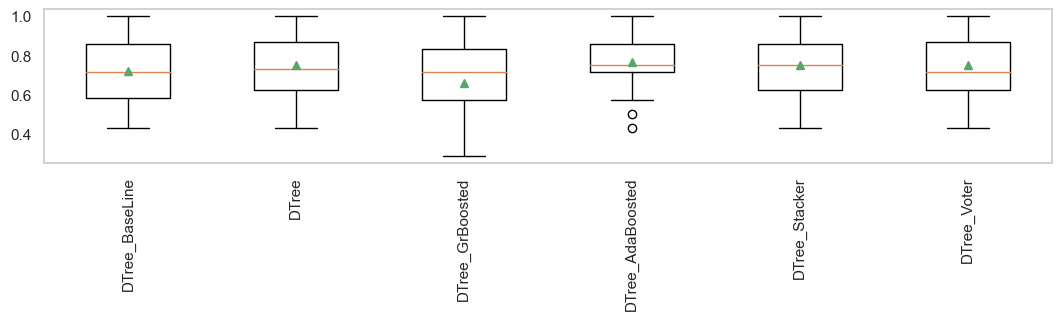

In [41]:
models = dict() 
models['DTree_BaseLine'    ] = DTree_BaseLine
models['DTree'             ] = DTree
models['DTree_GrBoosted'   ] = DTree_GrBoosted
models['DTree_AdaBoosted'  ] = DTree_AdaBoosted 
models['DTree_Stacker'     ] = DTree_Stacker
models['DTree_Voter'       ] = DTree_Voter
 

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=3)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results, names = list(), list()
print('                      Mean     SD       95% CI') 
for name, model in models.items():
    scores = evaluate_model( model, x_test_scaled, y_test )
    results.append(scores)
    names.append(name)
    print('>%19s  %.3f  (%.3f)  [%.2f %.2f]' % (name, mean(scores), std(scores), mean(scores)-2*std(scores), mean(scores)+2*std(scores)   ))
    
# plot model performance for comparison
plt.boxplot( results, labels=names, showmeans=True ); plt.xticks(rotation=90); plt.grid(False); plt.show()

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
 - **DTree_AdaBoosted** performs better than other estimators.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Evaluating DTree_AdaBoosted

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Visualizing

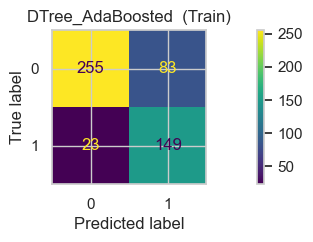

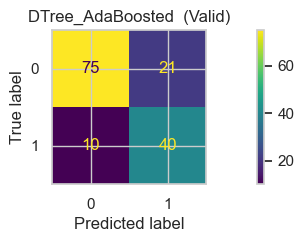

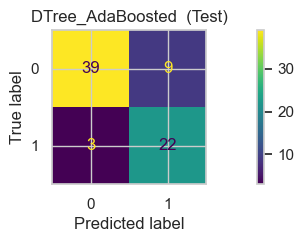

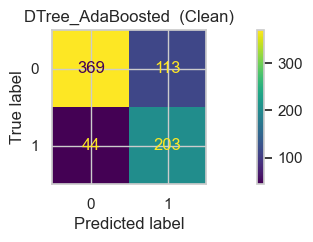

In [42]:
Classes  = ['0','1']
CLF      =  DTree_AdaBoosted
CLF_Name = 'DTree_AdaBoosted'

# Training Performance
figure = ConfusionMatrixDisplay.from_estimator( CLF, x_train_scaled, y_train, display_labels=Classes )
plt.title( CLF_Name+'  (Train)' ); plt.show()

# Valid Performance   
disp = ConfusionMatrixDisplay.from_estimator( CLF, x_valid_scaled, y_valid, display_labels=Classes  )
plt.title( CLF_Name+'  (Valid)' ); plt.show()

# Test Performance
disp = ConfusionMatrixDisplay.from_estimator( CLF, x_test_scaled,  y_test,  display_labels=Classes  )
plt.title( CLF_Name+'  (Test)' ); plt.show()

# clean Performance   
disp = ConfusionMatrixDisplay.from_estimator( CLF, x_clean_scaled, y_clean, display_labels=Classes  )
plt.title( CLF_Name+'  (Clean)' ); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing DTree_AdaBoosted with BaseLine on Test Data

In [43]:
y_pred = CLF.predict( x_test_scaled )
Report = classification_report( y_test, y_pred )
print( '\n'+CLF_Name,  '\n', Report )

y_pred = DTree_BaseLine.predict( x_test_scaled )
Report = classification_report( y_test, y_pred )
print( '\nDTree_BaseLine\n', Report )


DTree_AdaBoosted 
               precision    recall  f1-score   support

           0       0.93      0.81      0.87        48
           1       0.71      0.88      0.79        25

    accuracy                           0.84        73
   macro avg       0.82      0.85      0.83        73
weighted avg       0.85      0.84      0.84        73


DTree_BaseLine
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        48
           1       0.64      0.64      0.64        25

    accuracy                           0.75        73
   macro avg       0.73      0.73      0.73        73
weighted avg       0.75      0.75      0.75        73



##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - Compared to BaseLine:
 
   - **precision** of class 0 **improved +12%**
   - **precision** of class 1 **improved +7%**
    
   - **recall** of class 0 **improved +0%**
   - **recall** of class 1 **improved +24%**
   
   - **accuracy improved +9%**
**  **
 - Justification: As the Optimized Estimator is the fruit of **Cross-Validation** and **Adaptive-Boosting**, it is more **Reliable** than the BaseLine.

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Estimators To Disk

In [44]:
ESTIMATORS       = [  DTree_BaseLine ,  DTree ,  DTree_GrBoosted ,  DTree_AdaBoosted ,  DTree_Stacker ,  DTree_Voter  ]
ESTIMATORS_Names = [ 'DTree_BaseLine', 'DTree', 'DTree_GrBoosted', 'DTree_AdaBoosted', 'DTree_Stacker', 'DTree_Voter' ]

for i in range( len(ESTIMATORS) ):
    Estimator        = ESTIMATORS[ i ]
    Destination_File = ESTIMATORS_Names[ i ]+'.sav'
    pickle.dump( Estimator, open(Destination_File,'wb') )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Estimators From Disk

In [45]:
DTree_BaseLine   = pickle.load( open( 'DTree_BaseLine.sav'  ,'rb') )
DTree            = pickle.load( open( 'DTree.sav'           ,'rb') ) 
DTree_GrBoosted  = pickle.load( open( 'DTree_GrBoosted.sav' ,'rb') )
DTree_AdaBoosted = pickle.load( open( 'DTree_AdaBoosted.sav','rb') )
DTree_Stacker    = pickle.load( open( 'DTree_Stacker.sav'   ,'rb') )
DTree_Voter      = pickle.load( open( 'DTree_Voter.sav'     ,'rb') )

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making The Final Estimator

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checkig Range of Features

In [46]:
round( X_Train.describe().T[['min','max']], 3 )

,min,max
Test,15.0,459.165
Blood_Plasma,56.0,197.000
Age,21.0,68.000
Skin,8.0,54.000
Pregnancy,0.0,13.000
Body_Mass_Index,18.2,52.900
Blood_Pressure,38.0,108.000


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Choosing A Random Record To Be Predicted

In [47]:
# choosing a record in the test data set to be predicted
record_number = 1

df = X_Test.copy()
print( np.round( df.loc[  record_number  ,:], 1 ) )

print( '\nExpected_Class = ', y_Test[  record_number  ] )

Test               459.2
Blood_Plasma       155.0
Age                 46.0
Skin                26.0
Pregnancy            8.0
Body_Mass_Index     34.0
Blood_Pressure      62.0
Name: 1, dtype: float64

Expected_Class =  1


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Entering The Record of Interest and Acceptable Range

In [48]:
# input data                  R  a  n  g  e  

Test            = 459.2     # 15.0  459.165
Blood_Plasma    = 155.0     # 56.0  198.000
Age             =  46.0     # 21.0   68.000
Skin            =  26.0     #  8.0   54.000
Pregnancy       =   8.0     #  0.0   13.000
Body_Mass_Index =  34.0     # 18.2   52.900
Blood_Pressure  =  62.0     # 38.0  108.000

#Class          =   1.0    

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Predicting 

In [49]:
# x 
x = X_Train.copy()

# s  written in the same order as  X_Train
s = [ Test, Blood_Plasma, Age, Skin, Pregnancy, Body_Mass_Index, Blood_Pressure ]

encode_columns = [] 
def predicted_class( s, x, encode_columns ):
    s  = pd.DataFrame( [s.copy(),s.copy()], columns=x.columns )
    sx = pd.concat( [s,x], axis=0 )
    sx_encoded = pd.get_dummies(
          sx
        , columns = encode_columns
        )
    #print(sx_encoded.columns)
    sx_scaled = scale(  sx_encoded.iloc[1:,:]  )   
    sx_scaled = sx_scaled[[0,1]]  
    
    Estimator_Name, pred = [], [] 
    for key, value in models.items():
        clf = value
        Estimation = clf.predict( sx_scaled )[0]
        pred.append( Estimation ) 
        Estimator_Name.append( key )
        
    df_pred = pd.DataFrame( [pred] ).T
    df_pred.columns = ['Predicted Class']
    df_pred.index   = Estimator_Name
    
    return df_pred 

# Predicting
df_pred = predicted_class( s, x, encode_columns )
df_pred

,Predicted Class
DTree_BaseLine,0
DTree,1
DTree_GrBoosted,1
DTree_AdaBoosted,1
DTree_Stacker,1
DTree_Voter,1


#####   

#####   